In [1]:
#import data by kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Snake Dataset classication

In [2]:
!kaggle datasets download -d adityasharma01/snake-dataset-india

100% 65.4M/65.4M [00:02<00:00, 36.2MB/s]
100% 65.4M/65.4M [00:02<00:00, 26.8MB/s]


In [3]:
#file unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/snake-dataset-india.zip') 
zip_ref.extractall('/content/Data')
zip_ref.close()

In [4]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from  keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D
from keras.callbacks import EarlyStopping 

In [5]:
train_data = '/content/Data/Snake Images/train'
test_data = '/content/Data/Snake Images/test'

In [6]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(train_data,validation_split=0.2,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               subset="training",
                                                               seed=123)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_data,validation_split=0.2,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               subset="validation",
                                                               seed=123)

Found 1775 files belonging to 2 classes.
Using 1420 files for training.
Found 269 files belonging to 2 classes.
Using 53 files for validation.


In [7]:
class_names = train_data.class_names
class_names

['Non Venomous', 'Venomous']

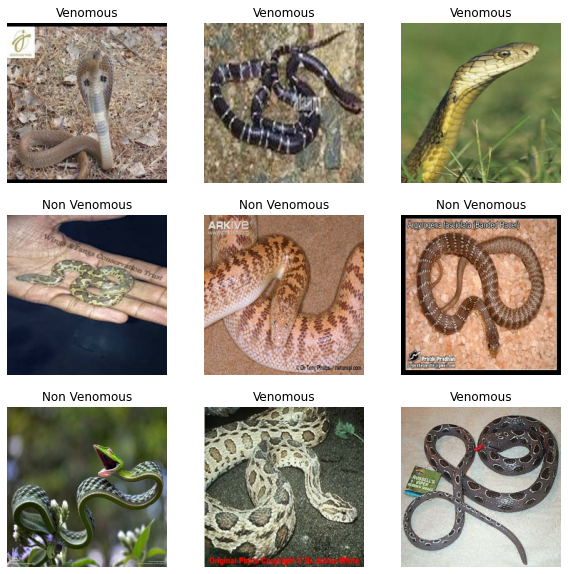

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
# Criando o modelo base em cima do modelo MobileNetV3
base_model = keras.applications.MobileNetV3Small(input_shape=(224, 224, 3),
                                            classes=400,
                                            include_top=False,
                                            weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [10]:
# Freeze convolutional base
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [11]:
data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2)
])

In [12]:
num_classes = len(class_names)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [13]:
#compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 2)                 1154      
                                                                 
Total params: 940,274
Trainable params: 1,154
Non-trainable p

In [14]:
#fitting model
initial_epochs = 15

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(train_data, 
          validation_data=test_data,
          epochs=initial_epochs,
          callbacks=[early_stop])

Epoch 1/15
45/45 [==============================] - 16s 96ms/step - loss: 0.7491 - accuracy: 0.6085 - val_loss: 0.7384 - val_accuracy: 0.4906
Epoch 2/15
45/45 [==============================] - 3s 49ms/step - loss: 0.5768 - accuracy: 0.6993 - val_loss: 0.6166 - val_accuracy: 0.6415
Epoch 3/15
45/45 [==============================] - 3s 50ms/step - loss: 0.5081 - accuracy: 0.7408 - val_loss: 0.5573 - val_accuracy: 0.6981
Epoch 4/15
45/45 [==============================] - 3s 52ms/step - loss: 0.4626 - accuracy: 0.7817 - val_loss: 0.5943 - val_accuracy: 0.6604


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()